<a href="https://colab.research.google.com/github/Bhavani-456/cicd_pipeline/blob/main/img_gen_no_api_key.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!nvidia-smi

Sat Jul 19 12:29:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   60C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!git clone https://github.com/openai/CLIP

Cloning into 'CLIP'...
remote: Enumerating objects: 256, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 256 (delta 126), reused 110 (delta 110), pack-reused 102 (from 1)
Receiving objects: 100% (256/256), 8.86 MiB | 9.36 MiB/s, done.
Resolving deltas: 100% (140/140), done.


In [4]:
!git clone https://github.com/CompVis/taming-transformers

Cloning into 'taming-transformers'...
remote: Enumerating objects: 1342, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 1342 (delta 0), reused 0 (delta 0), pack-reused 1341 (from 2)
Receiving objects: 100% (1342/1342), 409.77 MiB | 15.36 MiB/s, done.
Resolving deltas: 100% (282/282), done.


In [5]:
#we need to install some libraries as well
!pip install --no-deps ftfy regex tqdm
!pip install omegaconf==2.0.0 pytorch-lightning==1.0.8
!pip uninstall torchtext--yes
!pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 37.7 MB/s eta 0:00:00
  Attempting uninstall: omegaconf
    Found

In [6]:
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
#import PYTORCH libraries
import torch,os,imageio,pdb,math
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF

In [8]:
import yaml
from omegaconf import OmegaConf
from CLIP import clip
import warnings
warnings.filterwarnings('ignore')

In [9]:
## helper functions

def show_from_tensor(tensor):
  img = tensor.clone()
  img = img.mul(255).byte()
  img = img.cpu().numpy().transpose((1,2,0))

  plt.figure(figsize=(10,7))
  plt.axis('off')
  plt.imshow(img)
  plt.show()

def norm_data(data):
  return (data.clip(-1,1)+1)/2 ### range between 0 and 1 in the result

### Parameters
learning_rate = .5
batch_size = 1
wd = .1
noise_factor = .22

total_iter=400
im_shape = [450, 450, 3] # height, width, channel
size1, size2, channels = im_shape

In [10]:
### CLIP MODEL ###

clipmodel, _ = clip.load('ViT-B/32', jit=False)
clipmodel.eval()
print(clip.available_models())

print("Clip model visual input resolution: ", clipmodel.visual.input_resolution)

device=torch.device("cuda:0")
torch.cuda.empty_cache()

100%|███████████████████████████████████████| 338M/338M [00:10<00:00, 32.9MiB/s]


['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']
Clip model visual input resolution:  224


In [11]:
## Taming transformer instantiation
!git clone https://github.com/CompVis/taming-transformers
%cd taming-transformers/

!mkdir -p models/vqgan_imagenet_f16_16384/checkpoints
!mkdir -p models/vqgan_imagenet_f16_16384/configs

if len(os.listdir('models/vqgan_imagenet_f16_16384/checkpoints/')) == 0:
   !wget 'https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1&#1' -O 'models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt'
   !wget 'https://heibox.uni-heidelberg.de/f/274fb24ed38341bfa753/?dl=1&#1' -O 'models/vqgan_imagenet_f16_16384/configs/model.yaml'

fatal: destination path 'taming-transformers' already exists and is not an empty directory.
/content/taming-transformers
--2025-07-19 12:32:22--  https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1&
Resolving heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)... 129.206.7.113
Connecting to heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)|129.206.7.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://heibox.uni-heidelberg.de/seafhttp/files/e4464225-435c-4340-ac6f-179313c72de0/last.ckpt [following]
--2025-07-19 12:32:23--  https://heibox.uni-heidelberg.de/seafhttp/files/e4464225-435c-4340-ac6f-179313c72de0/last.ckpt
Reusing existing connection to heibox.uni-heidelberg.de:443.
HTTP request sent, awaiting response... 200 OK
Length: 980092370 (935M) [application/octet-stream]
Saving to: ‘models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt’

models/vqgan_imagen 100%[===================>] 934.69M  6.09MB/s    in 2m 45s  

2025-07-19 12:35:

In [12]:
import numpy as np
np.Inf=np.inf

In [22]:
from taming.models.vqgan import VQModel
import torch
from omegaconf import OmegaConf
import yaml
import torchvision # Added import

def load_config(config_path, display=False):
  config_data = OmegaConf.load(config_path)
  if display:
    print(yaml.dump(OmegaConf.to_container(config_data)))
  return config_data # Added return

def load_vqgan(config, chk_path=None):
  model = VQModel(**config.model.params)
  if chk_path is not None:
    state_dict = torch.load(chk_path, map_location="cpu", weights_only=False)["state_dict"] # Added weights_only=False
    missing, unexpected = model.load_state_dict(state_dict, strict=False)
  return model.eval() # Ensure model is returned

def generator(x):
  x = x.to(taming_model.device) # Move input tensor to the device of the taming_model
  print(f"Shape of input to post_quant_conv: {x.shape}") # Added print statement
  x = taming_model.post_quant_conv(x)
  print(f"Shape after post_quant_conv: {x.shape}") # Added print statement
  x = taming_model.decoder(x)
  print(f"Shape after decoder: {x.shape}") # Added print statement
  return x

taming_config = load_config("./models/vqgan_imagenet_f16_16384/configs/model.yaml", display=True)
taming_model = load_vqgan(taming_config, chk_path="./models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt").to(device)

model:
  base_learning_rate: 4.5e-06
  params:
    ddconfig:
      attn_resolutions:
      - 16
      ch: 128
      ch_mult:
      - 1
      - 1
      - 2
      - 2
      - 4
      double_z: false
      dropout: 0.0
      in_channels: 3
      num_res_blocks: 2
      out_ch: 3
      resolution: 256
      z_channels: 256
    embed_dim: 256
    lossconfig:
      params:
        codebook_weight: 1.0
        disc_conditional: false
        disc_in_channels: 3
        disc_num_layers: 2
        disc_start: 0
        disc_weight: 0.75
      target: taming.modules.losses.vqperceptual.VQLPIPSWithDiscriminator
    monitor: val/rec_loss
    n_embed: 16384
  target: taming.models.vqgan.VQModel

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


torch.Size([1, 256, 16, 16])
Shape of input to post_quant_conv: torch.Size([1, 256, 16, 16])
Shape after post_quant_conv: torch.Size([1, 256, 16, 16])
Shape after decoder: torch.Size([1, 3, 256, 256])
img dimensions:  torch.Size([1, 3, 256, 256])


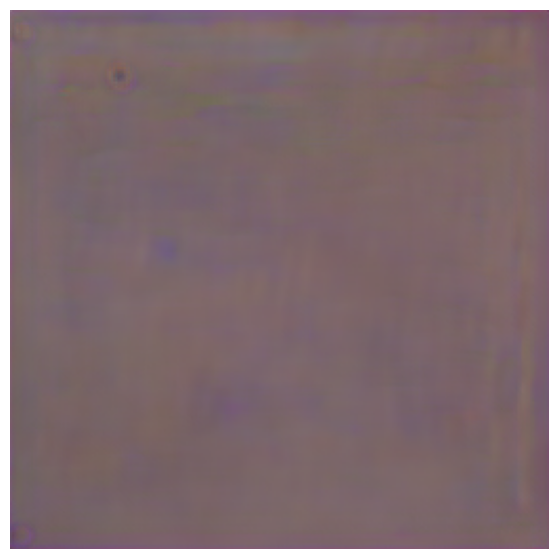

In [23]:
### Encoding prompts and a few more things
normalize = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

def encodeText(text):
  t=clip.tokenize(text).cuda()
  t=clipmodel.encode_text(t).detach().clone()
  return t

def createEncodings(include, exclude, extras):
  include_enc=[]
  for text in include:
    include_enc.append(encodeText(text))
  exclude_enc=encodeText(exclude) if exclude != '' else 0
  extras_enc=encodeText(extras) if extras !='' else 0

  return include_enc, exclude_enc, extras_enc

augTransform = torch.nn.Sequential(
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomAffine(30, (.2, .2), fill=0)
).cuda()

# Define init_params function
def init_params():
    # Placeholder for parameters and optimizer
    # You'll need to replace this with the actual initialization based on your model
    params = torch.nn.Parameter(torch.randn(1, 256, 16, 16)) # Example shape
    optimizer = torch.optim.Adam([params], lr=learning_rate) # Example optimizer
    return params, optimizer


Params, optimizer = init_params()

with torch.no_grad():
  print(Params.shape)
  img= norm_data(generator(Params.to(device)).cpu()) # Moved Params to device
  print("img dimensions: ",img.shape)
  show_from_tensor(img[0])

In [24]:
### create crops

def create_crops(img, num_crops=32):
  p=size1//2
  img = torch.nn.functional.pad(img, (p,p,p,p), mode='constant', value=0) # 1 x 3 x 448 x 624 (adding 112*2 on all sides to 224x400)

  img = augTransform(img) #RandomHorizontalFlip and RandomAffine

  crop_set = []
  for ch in range(num_crops):
    gap1= int(torch.normal(1.2, .3, ()).clip(.43, 1.9) * size1)
    offsetx = torch.randint(0, int(size1*2-gap1),())
    offsety = torch.randint(0, int(size1*2-gap1),())

    crop=img[:,:,offsetx:offsetx+gap1, offsety:offsety+gap1]

    crop = torch.nn.functional.interpolate(crop,(224,224), mode='bilinear', align_corners=True)
    crop_set.append(crop)

  img_crops=torch.cat(crop_set,0) ## 30 x 3 x 224 x 224

  randnormal = torch.randn_like(img_crops, requires_grad=False)
  num_rands=0
  randstotal=torch.rand((img_crops.shape[0],1,1,1)).cuda() #32

  for ns in range(num_rands):
    randstotal*=torch.rand((img_crops.shape[0],1,1,1)).cuda()

  img_crops = img_crops + noise_factor*randstotal*randnormal

  return img_crops

In [25]:
### Show current state of generation

def showme(Params, show_crop):
  with torch.no_grad():
    generated = generator(Params)

    if (show_crop):
      print("Augmented cropped example")
      aug_gen = generated.float() # 1 x 3 x 224 x 400
      aug_gen = create_crops(aug_gen, num_crops=1)
      aug_gen_norm = norm_data(aug_gen[0])
      show_from_tensor(aug_gen_norm)

    print("Generation")
    latest_gen=norm_data(generated.cpu()) # 1 x 3 x 224 x 400
    show_from_tensor(latest_gen[0])

  return (latest_gen[0])

In [26]:
# Optimization process
def optimize_result(Params, prompt):
    alpha = 1   # Importance of matching desired prompt
    beta = .5    # Importance of avoiding undesired prompt

    # Generate image from Params
    out = generator(Params)  # Move Params to GPU/CPU
    out = norm_data(out)
    out = create_crops(out)
    out = normalize(out)  # Shape: (30, 3, 224, 224)
    image_enc = clipmodel.encode_image(out)  # Shape: (30, 512)

    final_enc = w1*prompt + w1*extras_enc
    final_text_include_enc=final_enc/final_enc.norm(dim=-1, keepdim=True)
    final_text_exclude_enc=exclude_enc

    main_loss = torch.cosine_similarity(final_text_include_enc, image_enc,-1)  # Shape: (30,)
    penalize_loss = torch.cosine_similarity(final_text_exclude_enc, image_enc,-1)  # Shape: (30,)

    # Final loss: encourage similarity with prompt, discourage similarity with exclude
    final_loss = -alpha * main_loss + beta * penalize_loss

    return final_loss


# Perform one optimization step
def optimize(Params, optimizer, prompt):
    loss = optimize_result(Params, prompt).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

In [27]:
#training loop

def training_loop(params,optimizer,show_crop=False):
  res_img=[]
  res_z=[]

  for prompt in include_enc:
    iteration=0
    #params,optimizer=init_params()

    for it in range(total_iter):
      loss=optimize(params,optimizer,prompt)

      if iteration>=80 and iteration%show_step == 0:
       new_img=showme(params,show_crop)
       res_img.append(new_img)
       res_z.append(params)
       print("loss:",loss.item(),"\niteration:",iteration)

      iteration+=1
    torch.cuda.empty_cache()
    return res_img,res_z

Shape of input to post_quant_conv: torch.Size([1, 256, 16, 16])
Shape after post_quant_conv: torch.Size([1, 256, 16, 16])
Shape after decoder: torch.Size([1, 3, 256, 256])
Shape of input to post_quant_conv: torch.Size([1, 256, 16, 16])
Shape after post_quant_conv: torch.Size([1, 256, 16, 16])
Shape after decoder: torch.Size([1, 3, 256, 256])
Shape of input to post_quant_conv: torch.Size([1, 256, 16, 16])
Shape after post_quant_conv: torch.Size([1, 256, 16, 16])
Shape after decoder: torch.Size([1, 3, 256, 256])
Shape of input to post_quant_conv: torch.Size([1, 256, 16, 16])
Shape after post_quant_conv: torch.Size([1, 256, 16, 16])
Shape after decoder: torch.Size([1, 3, 256, 256])
Shape of input to post_quant_conv: torch.Size([1, 256, 16, 16])
Shape after post_quant_conv: torch.Size([1, 256, 16, 16])
Shape after decoder: torch.Size([1, 3, 256, 256])
Shape of input to post_quant_conv: torch.Size([1, 256, 16, 16])
Shape after post_quant_conv: torch.Size([1, 256, 16, 16])
Shape after decode

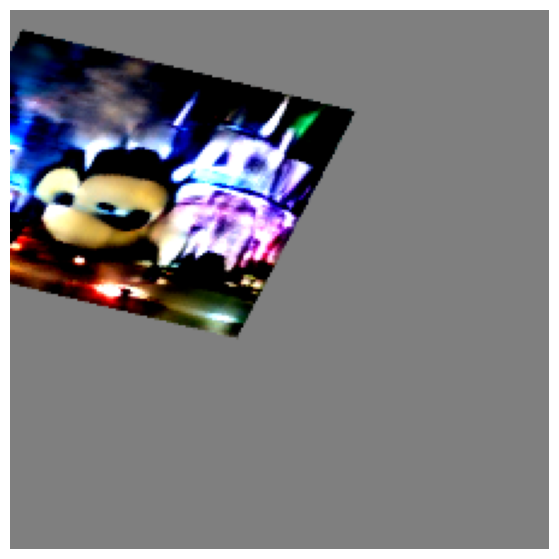

Generation


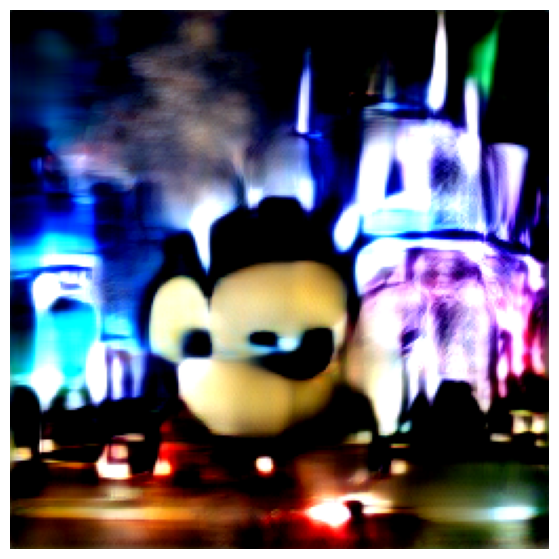

loss: -0.1734619140625 
iteration: 80
Shape of input to post_quant_conv: torch.Size([1, 256, 16, 16])
Shape after post_quant_conv: torch.Size([1, 256, 16, 16])
Shape after decoder: torch.Size([1, 3, 256, 256])
Shape of input to post_quant_conv: torch.Size([1, 256, 16, 16])
Shape after post_quant_conv: torch.Size([1, 256, 16, 16])
Shape after decoder: torch.Size([1, 3, 256, 256])
Shape of input to post_quant_conv: torch.Size([1, 256, 16, 16])
Shape after post_quant_conv: torch.Size([1, 256, 16, 16])
Shape after decoder: torch.Size([1, 3, 256, 256])
Shape of input to post_quant_conv: torch.Size([1, 256, 16, 16])
Shape after post_quant_conv: torch.Size([1, 256, 16, 16])
Shape after decoder: torch.Size([1, 3, 256, 256])
Shape of input to post_quant_conv: torch.Size([1, 256, 16, 16])
Shape after post_quant_conv: torch.Size([1, 256, 16, 16])
Shape after decoder: torch.Size([1, 3, 256, 256])
Shape of input to post_quant_conv: torch.Size([1, 256, 16, 16])
Shape after post_quant_conv: torch.Siz

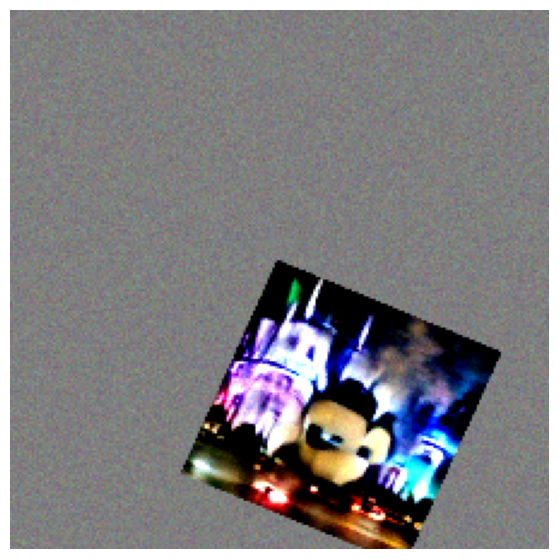

Generation


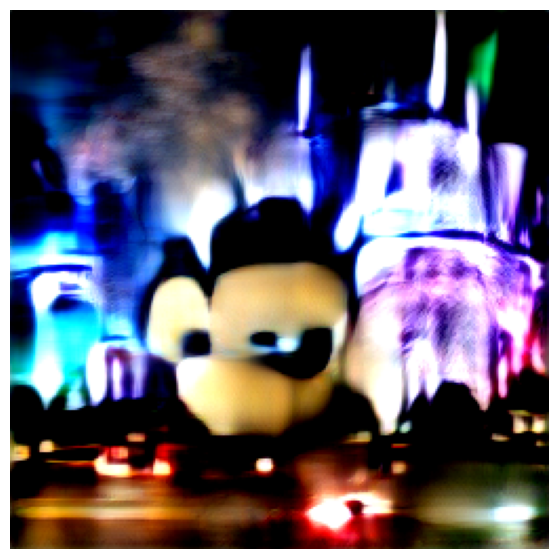

loss: -0.200927734375 
iteration: 90
Shape of input to post_quant_conv: torch.Size([1, 256, 16, 16])
Shape after post_quant_conv: torch.Size([1, 256, 16, 16])
Shape after decoder: torch.Size([1, 3, 256, 256])
Shape of input to post_quant_conv: torch.Size([1, 256, 16, 16])
Shape after post_quant_conv: torch.Size([1, 256, 16, 16])
Shape after decoder: torch.Size([1, 3, 256, 256])
Shape of input to post_quant_conv: torch.Size([1, 256, 16, 16])
Shape after post_quant_conv: torch.Size([1, 256, 16, 16])
Shape after decoder: torch.Size([1, 3, 256, 256])
Shape of input to post_quant_conv: torch.Size([1, 256, 16, 16])
Shape after post_quant_conv: torch.Size([1, 256, 16, 16])
Shape after decoder: torch.Size([1, 3, 256, 256])
Shape of input to post_quant_conv: torch.Size([1, 256, 16, 16])
Shape after post_quant_conv: torch.Size([1, 256, 16, 16])
Shape after decoder: torch.Size([1, 3, 256, 256])
Shape of input to post_quant_conv: torch.Size([1, 256, 16, 16])
Shape after post_quant_conv: torch.Size

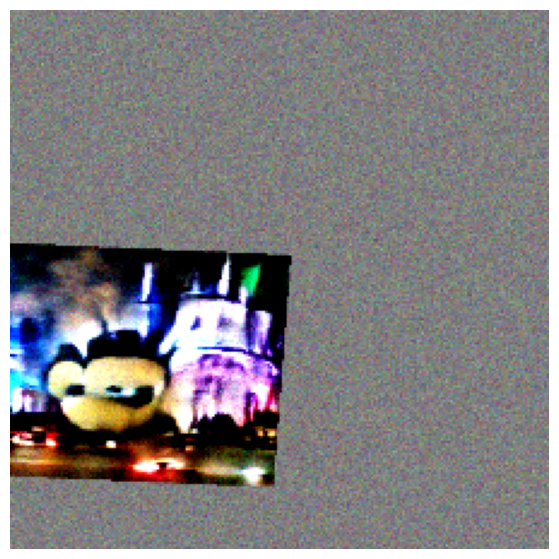

Generation


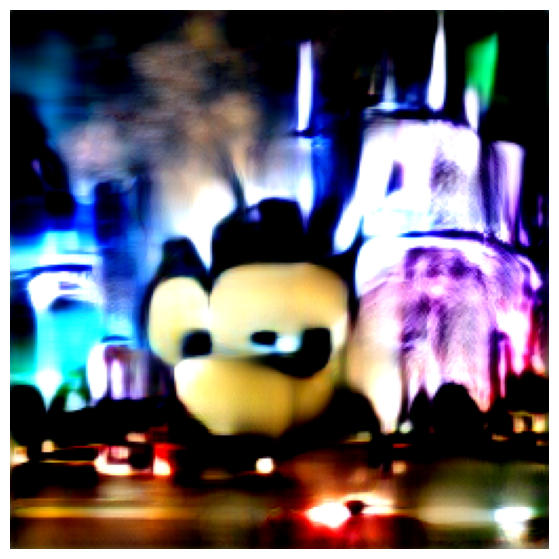

loss: -0.2076416015625 
iteration: 100
Shape of input to post_quant_conv: torch.Size([1, 256, 16, 16])
Shape after post_quant_conv: torch.Size([1, 256, 16, 16])
Shape after decoder: torch.Size([1, 3, 256, 256])
Shape of input to post_quant_conv: torch.Size([1, 256, 16, 16])
Shape after post_quant_conv: torch.Size([1, 256, 16, 16])
Shape after decoder: torch.Size([1, 3, 256, 256])
Shape of input to post_quant_conv: torch.Size([1, 256, 16, 16])
Shape after post_quant_conv: torch.Size([1, 256, 16, 16])
Shape after decoder: torch.Size([1, 3, 256, 256])
Shape of input to post_quant_conv: torch.Size([1, 256, 16, 16])
Shape after post_quant_conv: torch.Size([1, 256, 16, 16])
Shape after decoder: torch.Size([1, 3, 256, 256])
Shape of input to post_quant_conv: torch.Size([1, 256, 16, 16])
Shape after post_quant_conv: torch.Size([1, 256, 16, 16])
Shape after decoder: torch.Size([1, 3, 256, 256])
Shape of input to post_quant_conv: torch.Size([1, 256, 16, 16])
Shape after post_quant_conv: torch.Si

In [28]:
torch.cuda.empty_cache()
include=['disney world']
exclude='watermark'
extras=""
w1=1
w2=1
noise_factor= .22
total_iter=110
show_step=10
include_enc, exclude_enc, extras_enc = createEncodings(include, exclude, extras)
res_img, res_z=training_loop(Params, optimizer, show_crop=True)